# Generate final LLM DVs per tasl

Starting point:
- dataset with itemlevel values for each task for participants

Goal:
- calculate the final DVs like I did for the LLM partid data to then compare outcomes with Frey calculated outcomes

In [201]:
# packages and data

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns
import ast


# load overall df
all_data = pd.read_csv("human_data/items_per_person.csv")

/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_22212/1144630107.py:18: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv("human_data/items_per_person.csv")


### AUDIT SCALE

In [202]:
# extract AUDIT experiment, and sum up score overall
AUDIT_SUB= all_data[all_data["experiment"] == "AUDIT scale"]
AUDIT_DV_DF = AUDIT_SUB.groupby(["partid"])["score"].sum().reset_index()

# extract item 1 and if any partid scored 0 (i.e. 2)
item1 = AUDIT_SUB[AUDIT_SUB["item"] == 1][["partid", "score"]]
item1 = item1.rename(columns={"score": "item1_score"})

AUDIT_DV_DF = AUDIT_DV_DF.merge(item1, on="partid")

# if any partid scored 2, 0 stays, else add 1 and compute the log, that is the DV of AUDIT (as described in Frey)
AUDIT_DV_DF["score"] = np.where(
    AUDIT_DV_DF["item1_score"] == 2,
    0,
    np.log(AUDIT_DV_DF["score"] + 1)
)

# rename column to concat with rest of data
AUDIT_DV_DF = AUDIT_DV_DF[["partid", "score"]].rename(columns={"score": "AUDIT"})


### BARRAT SCALE
- if I understand it correctly (no docu) sum per subscale

In [203]:
BARRAT_SUB= all_data[all_data["experiment"] == "BARRAT scale"]
BARRAT_DV_DF = BARRAT_SUB.groupby(["partid", "category"])["score"].sum().reset_index()
BARRAT_DV_DF = BARRAT_DV_DF.pivot(index="partid", columns="category", values="score")


In [204]:
# add_new_df
DV_data = pd.merge(AUDIT_DV_DF[["partid", "AUDIT"]], 
                    BARRAT_DV_DF, 
                    on="partid",
                    how = "outer")


### CARE SCALE

- binned factors, sum up each category and see in which level (in level_stats) it falls 

In [205]:
CARE_SUB= all_data[all_data["experiment"] == "CARE scale"]
CARE_DV_DF = CARE_SUB.groupby(["partid", "category"])["score"].sum().reset_index()
# recode according to defined categories (Frey et al)
def recode_care(row):
    if row['category'] == 'CAREw':  # carework
        if 0 <= row['score'] < 3:
            return 0
        elif 3 <= row['score'] < 8:
            return 1
        elif 8 <= row['score'] < 17:
            return 2
        else:  # 17 and above
            return 3
    elif row['category'] == 'CAREa':  # careaggr
        if row['score'] == 0:
            return 0
        elif 1 <= row['score'] < 5:
            return 1
        else:  # 5 and above
            return 2
    elif row['category'] == 'CAREs':  # caresex
        if 0 <= row['score'] < 2:
            return 0
        elif 2 <= row['score'] < 8:
            return 1
        else:  # 8 and above
            return 2
        
CARE_DV_DF['score'] = CARE_DV_DF.apply(recode_care, axis=1)

# pivot longer for final form 
CARE_DV_DF = CARE_DV_DF.pivot(index="partid", columns="category", values="score")


In [206]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    CARE_DV_DF,
    on="partid",
    how="outer"
)

### DAST SCALE
- It should be a binned factor:
0 = 0,
1 = 1-18

But when I do that, no discrimination/variation at all, therefore leave it out for now and ask Dirk

In [207]:
DAST_SUB= all_data[all_data["experiment"] == "DAST scale"]
DAST_DV_DF = DAST_SUB.groupby(["partid"])["score"].sum().reset_index()


In [208]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DAST_DV_DF[["partid", "score"]].rename(columns={"score": "DAST"}),
    on="partid",
    how="outer"
)

### DM SCALE
- sum was computed from the following values in each item: 0=never, 1=once or twice, 2=several times, 0=not applicable (mapping done in postprocessing)
- LLM probabilities were already weighed with these values, therefore we can simply sum up

In [209]:
DM_SUB= all_data[all_data["experiment"] == "Dm scale"]
DM_DV_DF = DM_SUB.groupby(["partid"])["score"].sum().reset_index() 


In [210]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DM_DV_DF[["partid", "score"]].rename(columns={"score": "DM"}),
    on="partid",
    how="outer"
)

### DOSPERT SCALE
- if I understand it correctly (no docu) mean per subscale

In [211]:
DOSPERT_SUB= all_data[all_data["experiment"] == "DOSPERT scale"]
DOSPERT_DV_DF = DOSPERT_SUB.groupby(["partid", "category"])["score"].mean().reset_index()
DOSPERT_DV_DF = DOSPERT_DV_DF.pivot(index="partid", columns="category", values="score")


# rename column to concat with rest of data
DOSPERT_DV_DF = DOSPERT_DV_DF.rename(columns={
    "Ethical": "Deth",
    "Gambling": "Dgam",
    "Health": "Dhea",
    "Investment": "Dinv",
    "Recreational": "Drec",
    "Social": "Dsoc",

    })



In [212]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DOSPERT_DV_DF,
    on="partid",
    how="outer"
)

### FTND SCALE
- binned factor of sum score (I think)
- same issue as with DAST, since level 0 and 1 are seperated from 0 to 1 till end, would be no discrimination, leaving as is

In [213]:
FTND_SUB= all_data[all_data["experiment"] == "FTND scale"]
FTND_DV_DF = FTND_SUB.groupby(["partid"])["score"].sum().reset_index()


In [214]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    FTND_DV_DF[["partid", "score"]].rename(columns={"score": "FTND"}),
    on="partid",
    how="outer"
)

### GABS SCALE
- binned factor of sum score (think again)
- weird: in Frey et al, they divide into dfactors: 0 = up to 15, 1 = 15 to 60
- they probably do some form of refactoring of the item 2-16 (since they are going from 1-5or so) (because summing up while using different scales, weird)
- also leaving as is for now

In [215]:
GABS_SUB= all_data[all_data["experiment"] == "GABS scale"]
GABS_DV_DF = GABS_SUB.groupby(["partid"])["score"].sum().reset_index()


In [216]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    GABS_DV_DF[["partid", "score"]].rename(columns={"score": "GABS"}),
    on="partid",
    how="outer"
)

### PG SCALE
- again binned factor of sum score
- but because the levels are 0=0, 1=1-36, would not make sense here

In [217]:
PG_SUB= all_data[all_data["experiment"] == "PG scale"]
PG_DV_DF = PG_SUB.groupby(["partid"])["score"].sum().reset_index()


In [218]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    PG_DV_DF[["partid", "score"]].rename(columns={"score": "PG"}),
    on="partid",
    how="outer"
)

### PRI SCALE
- no docu, nothing, I have NO IDEA how to get to a sensible score in that task
- using sum for now

In [219]:
PRI_SUB= all_data[all_data["experiment"] == "PRI scale"]
PRI_DV_DF = PRI_SUB.groupby(["partid", "category"])["score"].sum().reset_index()
PRI_DV_DF = PRI_DV_DF.pivot(index="partid", columns="category", values="score")


# rename column to concat with rest of data
PRI_DV_DF = PRI_DV_DF.rename(columns={
    "certainty": "PRI_certainty",
    "decision": "PRI_decision",

    })

In [220]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    PRI_DV_DF,
    on="partid",
    how="outer"
)

### SOEP SCALE

- simply stays the same, every value in one sub category is one value

In [221]:
SOEP_SUB= all_data[all_data["experiment"] == "SOEP scale"]
SOEP_DV_DF = SOEP_SUB.pivot(index="partid", columns="category", values="score")

In [222]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    SOEP_DV_DF,
    on="partid",
    how="outer"
)

### SSSV SCALE

- I guess summing over sub categories?!

In [223]:
SSSV_SUB= all_data[all_data["experiment"] == "SSSV scale"]
SSSV_DV_DF = SSSV_SUB.groupby(["partid", "category"])["score"].sum().reset_index()
SSSV_DV_DF = SSSV_DV_DF.pivot(index="partid", columns="category", values="score")


In [224]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    SSSV_DV_DF,
    on="partid",
    how="outer"
)

### BART TASK

- mean number of pumps over trials (items)

In [225]:
BART_SUB= all_data[all_data["experiment"] == "BART task"]
BART_DV_DF = BART_SUB.groupby(["partid"])["score"].mean().reset_index()
#BART_DV_DF

In [226]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    BART_DV_DF[["partid", "score"]].rename(columns={"score": "BART"}),
    on="partid",
    how="outer"
)

### CCT TASK
- sum of all cards drawn (scores of all items per person summed up)

In [227]:
CCT_SUB= all_data[all_data["experiment"] == "CCT task"]
CCT_DV_DF = CCT_SUB.groupby(["partid"])["score"].sum().reset_index()
#CCT_DV_DF

In [228]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    CCT_DV_DF[["partid", "score"]].rename(columns={"score": "CCT"}),
    on="partid",
    how="outer"
)

### DFD TASK

- DFD is the proportion of risky choices out of all choices
- i.e. sum(choices)/len(choices), mean
- in human samples, the item answers would all be "0" or "1", but since we already weighed with all human answers, we already have decimal numbers between 0 and 1, indicating more fine-grained answers per item already

In [229]:
DFD_SUB= all_data[all_data["experiment"] == "DFD task"]
DFD_DV_DF = DFD_SUB.groupby(["partid"])["score"].mean().reset_index()
#DFD_DV_DF

In [230]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DFD_DV_DF[["partid", "score"]].rename(columns={"score": "DFD"}),
    on="partid",
    how="outer"
)

### DFE TASK
- same as DFD
- DFE re is the proportion of risky choices out of all choices
- i.e. sum(choices)/len(choices), mean
- in human samples, the item answers would all be "0" or "1", but since we already weighed with all human answers, we already have decimal numbers between 0 and 1, indicating more fine-grained answers per item already

In [231]:
DFE_SUB= all_data[all_data["experiment"] == "DFE task"]
DFE_DV_DF = DFE_SUB.groupby(["partid"])["score"].mean().reset_index()
#DFE_DV_DF

In [232]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DFE_DV_DF[["partid", "score"]].rename(columns={"score": "DFE"}),
    on="partid",
    how="outer"
)

### LOT TASK

- mean i.e. proportion of risky choices out of the 25 trials.

In [233]:
LOT_SUB= all_data[all_data["experiment"] == "LOT task"]
LOT_DV_DF = LOT_SUB.groupby(["partid"])["score"].mean().reset_index()
#LOT_DV_DF

In [234]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    LOT_DV_DF[["partid", "score"]].rename(columns={"score": "LOT"}),
    on="partid",
    how="outer"
)

### MPL TASK
- switching point:
    - only the first of all rounds is taken into consideration
    - there it is looked at the switching point (the first decision for the riskier choice)

- I will also only consider the first round, look at the scores and round probabilities under 0.5 to 0 and from 0.5 on to 1. 
- then I will define the switching point of a partid as the first 1 decision. (=DV)

In [235]:
# filter only MPL data and filter only data for the first round, (since round 2-7 are ignored for the DV)
MPL_SUB= all_data[all_data["experiment"] == "MPL task"]

def parse_tuple(s):
    if isinstance(s, str) and s.startswith("(") and s.endswith(")"):
        a, b = s[1:-1].split(",")
        try:
            return float(a), float(b)
        except:
            return None
    return None

MPL_SUB["item"] = MPL_SUB["item"].apply(parse_tuple)
MPL_SUB_ROUND_1 = MPL_SUB[MPL_SUB["item"].apply(lambda x: x and x[0] == 1)]

/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_22212/3252915943.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPL_SUB["item"] = MPL_SUB["item"].apply(parse_tuple)


In [236]:
# define the switching point by first transforming all scores to 0 or 1 (depends on whether they are bigger than 0.5)
MPL_SUB_ROUND_1["decision"] = np.where(
    MPL_SUB_ROUND_1["score"] <= 0.5,
    0,
    1
)

#MPL_SUB_ROUND_1.tail(50)

/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_22212/1789067762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPL_SUB_ROUND_1["decision"] = np.where(


In [237]:
# not yet happy with, current sum up technique to simulate switching point
MPL_DV_DF = MPL_SUB_ROUND_1.groupby(["partid"])["decision"].sum().reset_index()
#MPL_DV_DF

In [238]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    MPL_DV_DF[["partid", "decision"]].rename(columns={"decision": "MPL"}),
    on="partid",
    how="outer"
)

## Preliminary Results

In [239]:
DV_data.to_csv('human_data/human_DV_data/final_DVs_humans.csv', index=False)

In [240]:
DV_data.columns

Index(['partid', 'AUDIT', 'BISa', 'BISm', 'BISn', 'CAREa', 'CAREs', 'CAREw',
       'DAST', 'DM', 'Deth', 'Dgam', 'Dhea', 'Dinv', 'Drec', 'Dsoc', 'FTND',
       'GABS', 'PG', 'PRI_certainty', 'PRI_decision', 'SOEP', 'SOEPdri',
       'SOEPfin', 'SOEPhea', 'SOEPocc', 'SOEPrec', 'SOEPsoc', 'SSbor', 'SSdis',
       'SSexp', 'SStas', 'BART', 'CCT', 'DFD', 'DFE', 'LOT', 'MPL'],
      dtype='object')

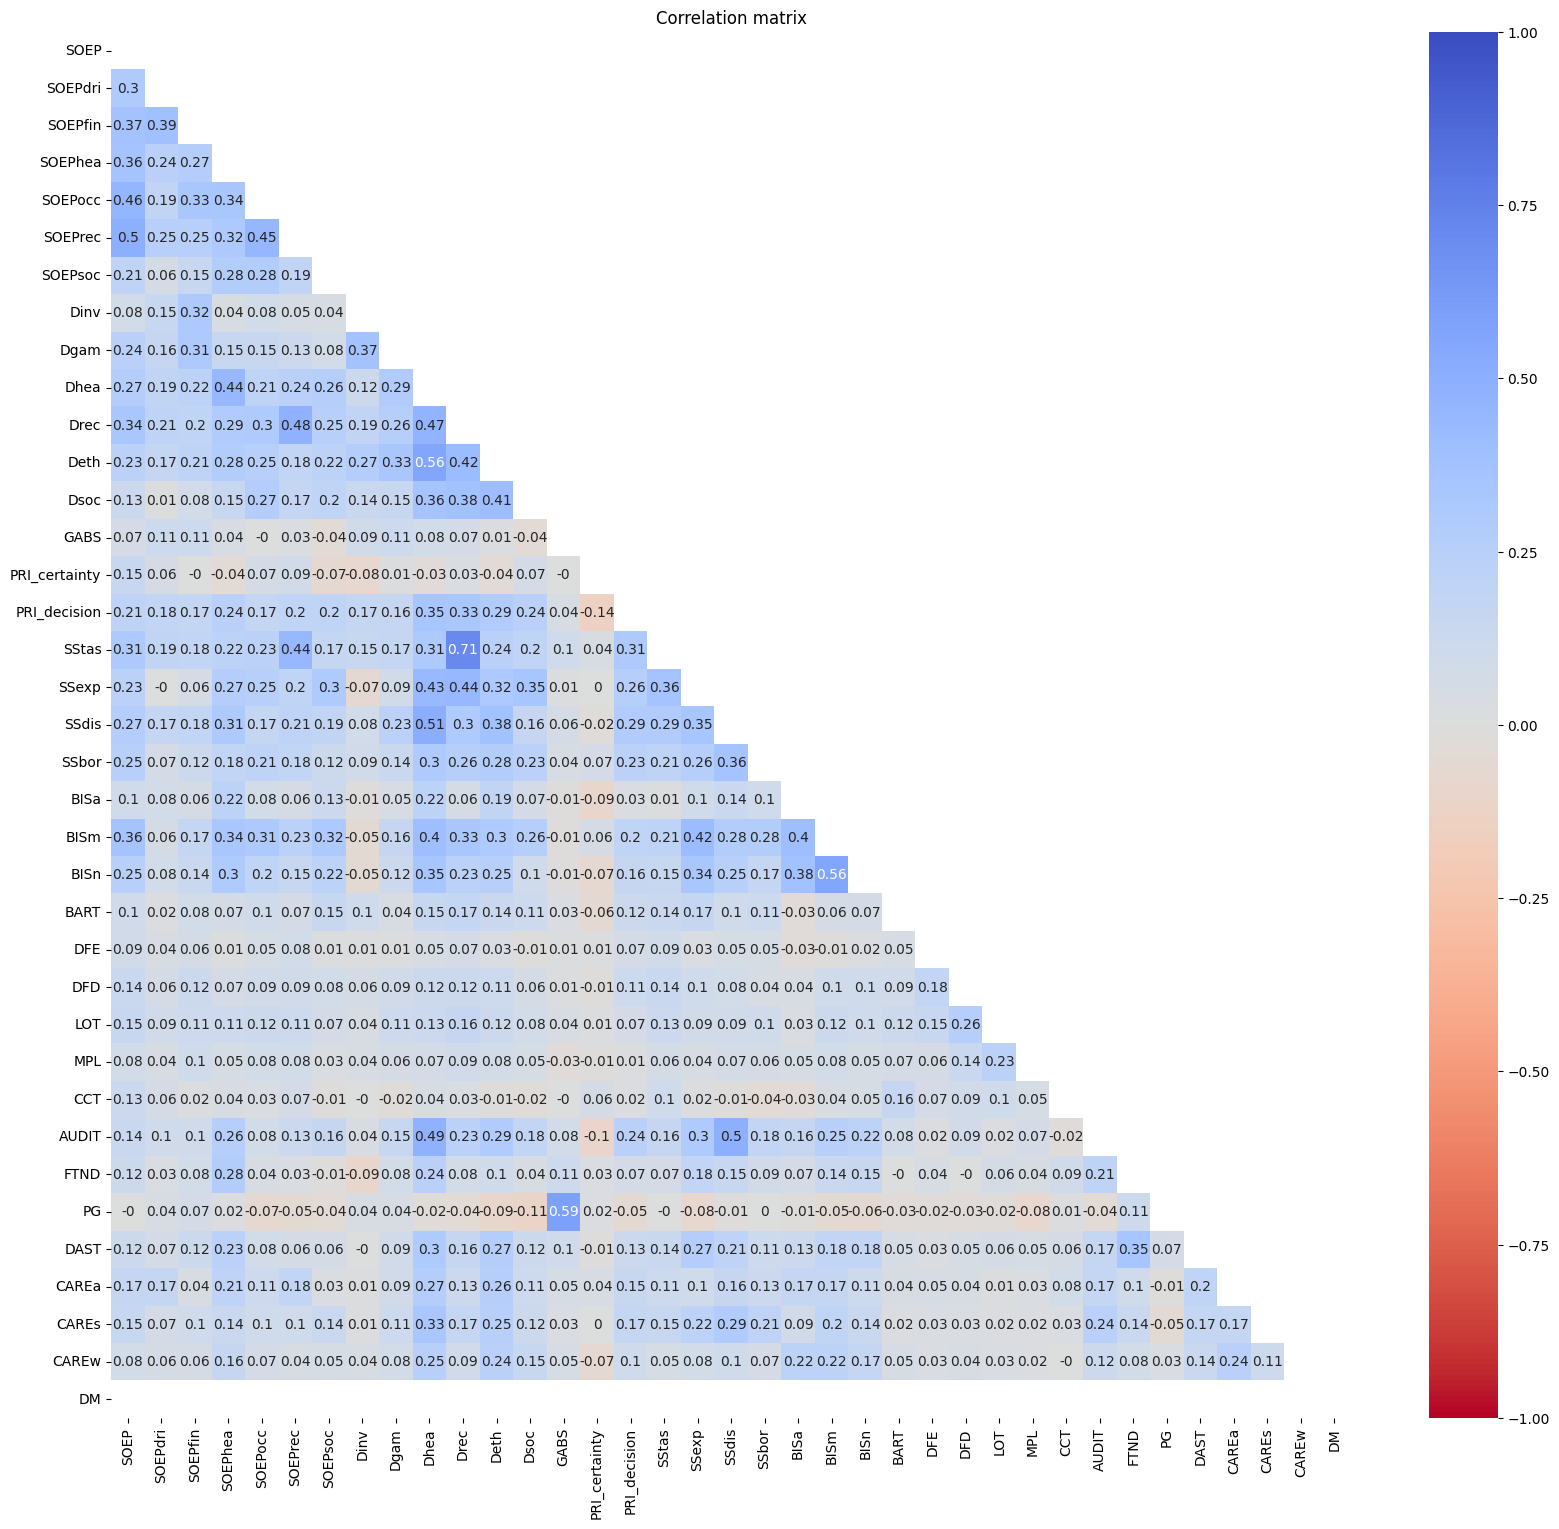

In [241]:
# Compute correlation matrix (only for numeric columns)
numeric_df = DV_data.drop(columns=['partid'])
corr = numeric_df.corr().round(2)

# reorder to compare with human data
order = ['SOEP', 'SOEPdri', 'SOEPfin', 'SOEPhea', 'SOEPocc', 'SOEPrec', 'SOEPsoc',
        'Dinv', 'Dgam', 'Dhea', 'Drec', 'Deth', 'Dsoc', 'GABS', 'PRI_certainty', 'PRI_decision', 
        'SStas', 'SSexp', 'SSdis', 'SSbor', 'BISa', 'BISm', 'BISn', 'BART', 'DFE', 'DFD', 'LOT', 'MPL', 'CCT', 
         'AUDIT', 'FTND', 'PG', 'DAST', 'CAREa', 'CAREs', 'CAREw', 'DM']  

corr_reordered = corr.loc[order, order].round(2)

# Display it as a heatmap
# plt.figure(figsize=(20, 18))
# sns.heatmap(corr, annot=True, cmap="coolwarm_r", vmin=-1, vmax=1)
# plt.title("Correlation matrix of model scores")
# plt.show()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_reordered, dtype=bool))

# Plot heatmap with mask
plt.figure(figsize=(20, 18))
sns.heatmap(
    corr_reordered,
    mask=mask,
    annot=True,
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1
)
plt.title("Correlation matrix")
plt.show()
